# Artificial Neural Networks

#### Name: 沈家駿
#### Student ID: 0712223

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Data Input

### Read train.json

In [2]:
with open('train.json') as f:
    train_data = json.load(f)

In [3]:
df = pd.json_normalize(train_data)

In [4]:
df

,id,cuisine,ingredients
0,42302,southern_us,"[egg whites, pecans, agave nectar, ground cinn..."
1,43202,greek,"[large egg whites, whole milk, bread crumb fre..."
2,31619,cajun_creole,"[sugar, vegetable oil, yeast, eggs, evaporated..."
3,30920,korean,"[honey, rice vinegar, brown sugar, ginger, gar..."
4,46567,italian,"[mushroom caps, asiago, large shrimp, fat free..."
...,...,...,...
29769,24516,greek,"[mayonaise, mahimahi fillet, tomatoes, extra-v..."
29770,49253,mexican,"[neutral oil, ground black pepper, tomatillos,..."
29771,4861,french,"[tomatoes, chopped fresh thyme, fresh mushroom..."
29772,529,mexican,"[unsalted butter, chees fresco queso, lime, ch..."


In [5]:
with open('test.json') as f:
    test_data = json.load(f)

## Data Visualization

### Plot the data distribution by value count of their labels (targets).

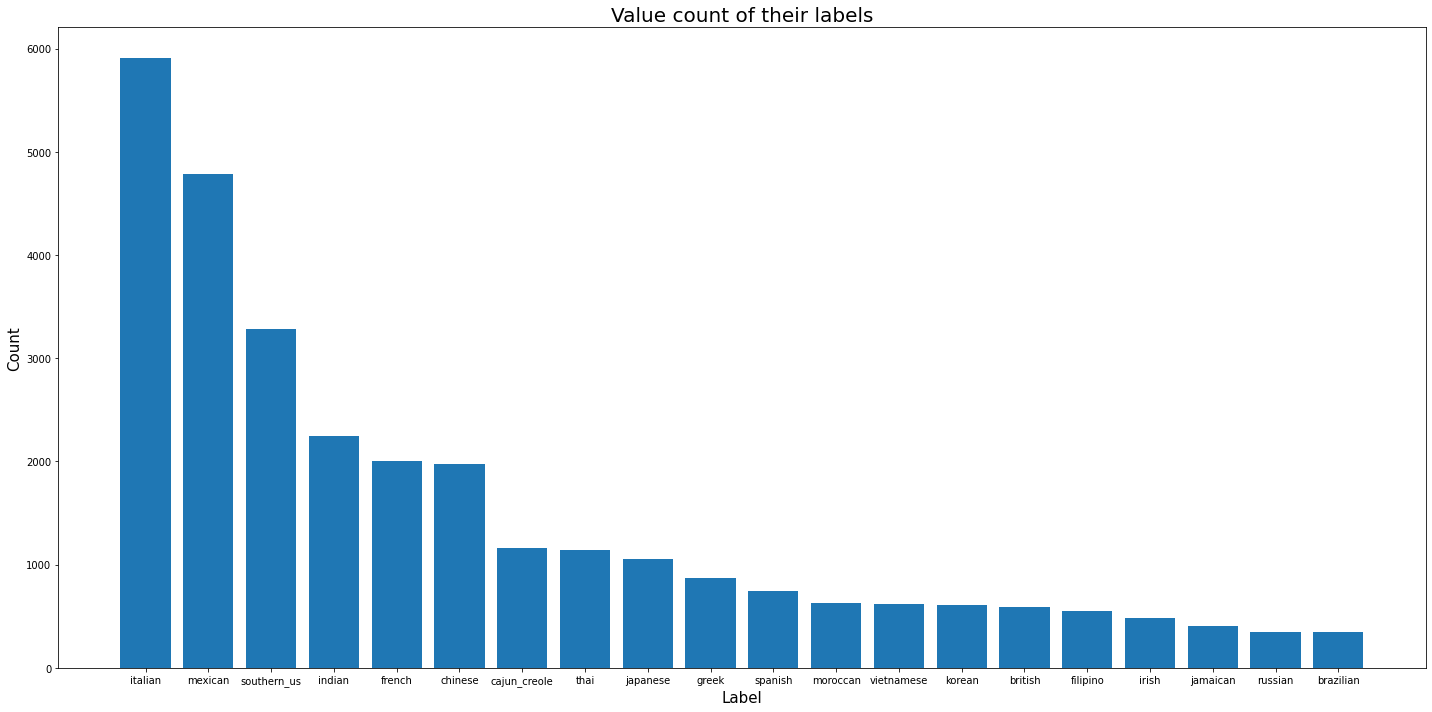

In [6]:
cuisine_val_cnt = df['cuisine'].value_counts()
plt.figure(figsize=(20, 10))
plt.bar(cuisine_val_cnt.index, cuisine_val_cnt.values)
plt.title("Value count of their labels", fontsize=20) 
plt.ylabel("Count", fontsize=15) 
plt.xlabel("Label", fontsize=15) 
plt.tight_layout()

### Plot the data distribution by value count of top 30 features.

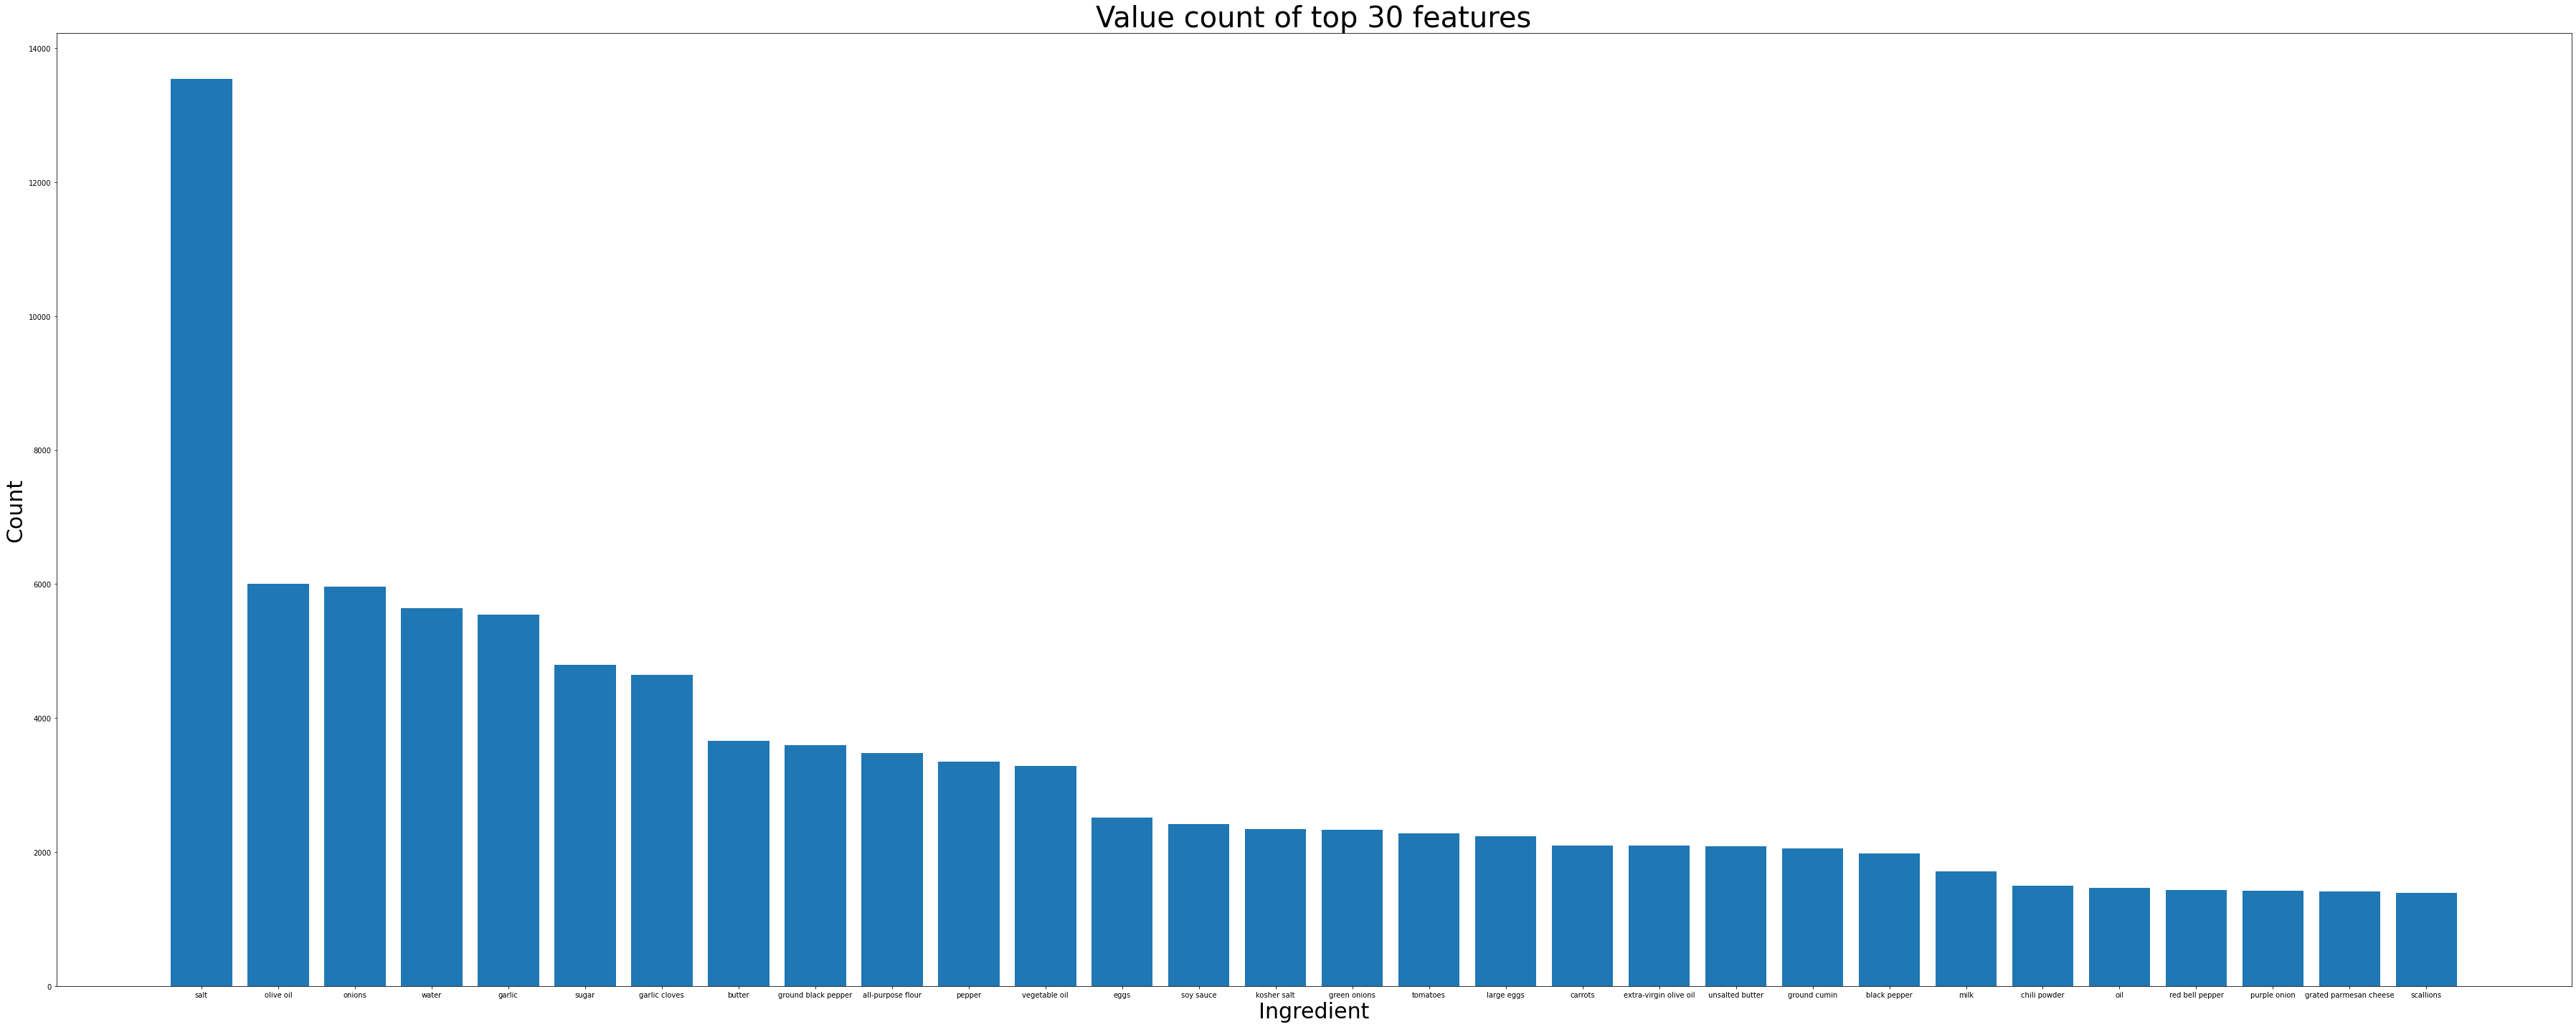

In [7]:
def flatten(series):
    return pd.Series([x for li in series for x in li])
top30_val_cnt = flatten(df['ingredients']).value_counts()[:30]

plt.figure(figsize=(50, 20))
plt.bar(top30_val_cnt.index, top30_val_cnt.values)
plt.title("Value count of top 30 features", fontsize=40) 
plt.ylabel("Count", fontsize=30) 
plt.xlabel("Ingredient", fontsize=30) 
plt.tight_layout()

### Plot the data distribution by value count of the number of ingredients.

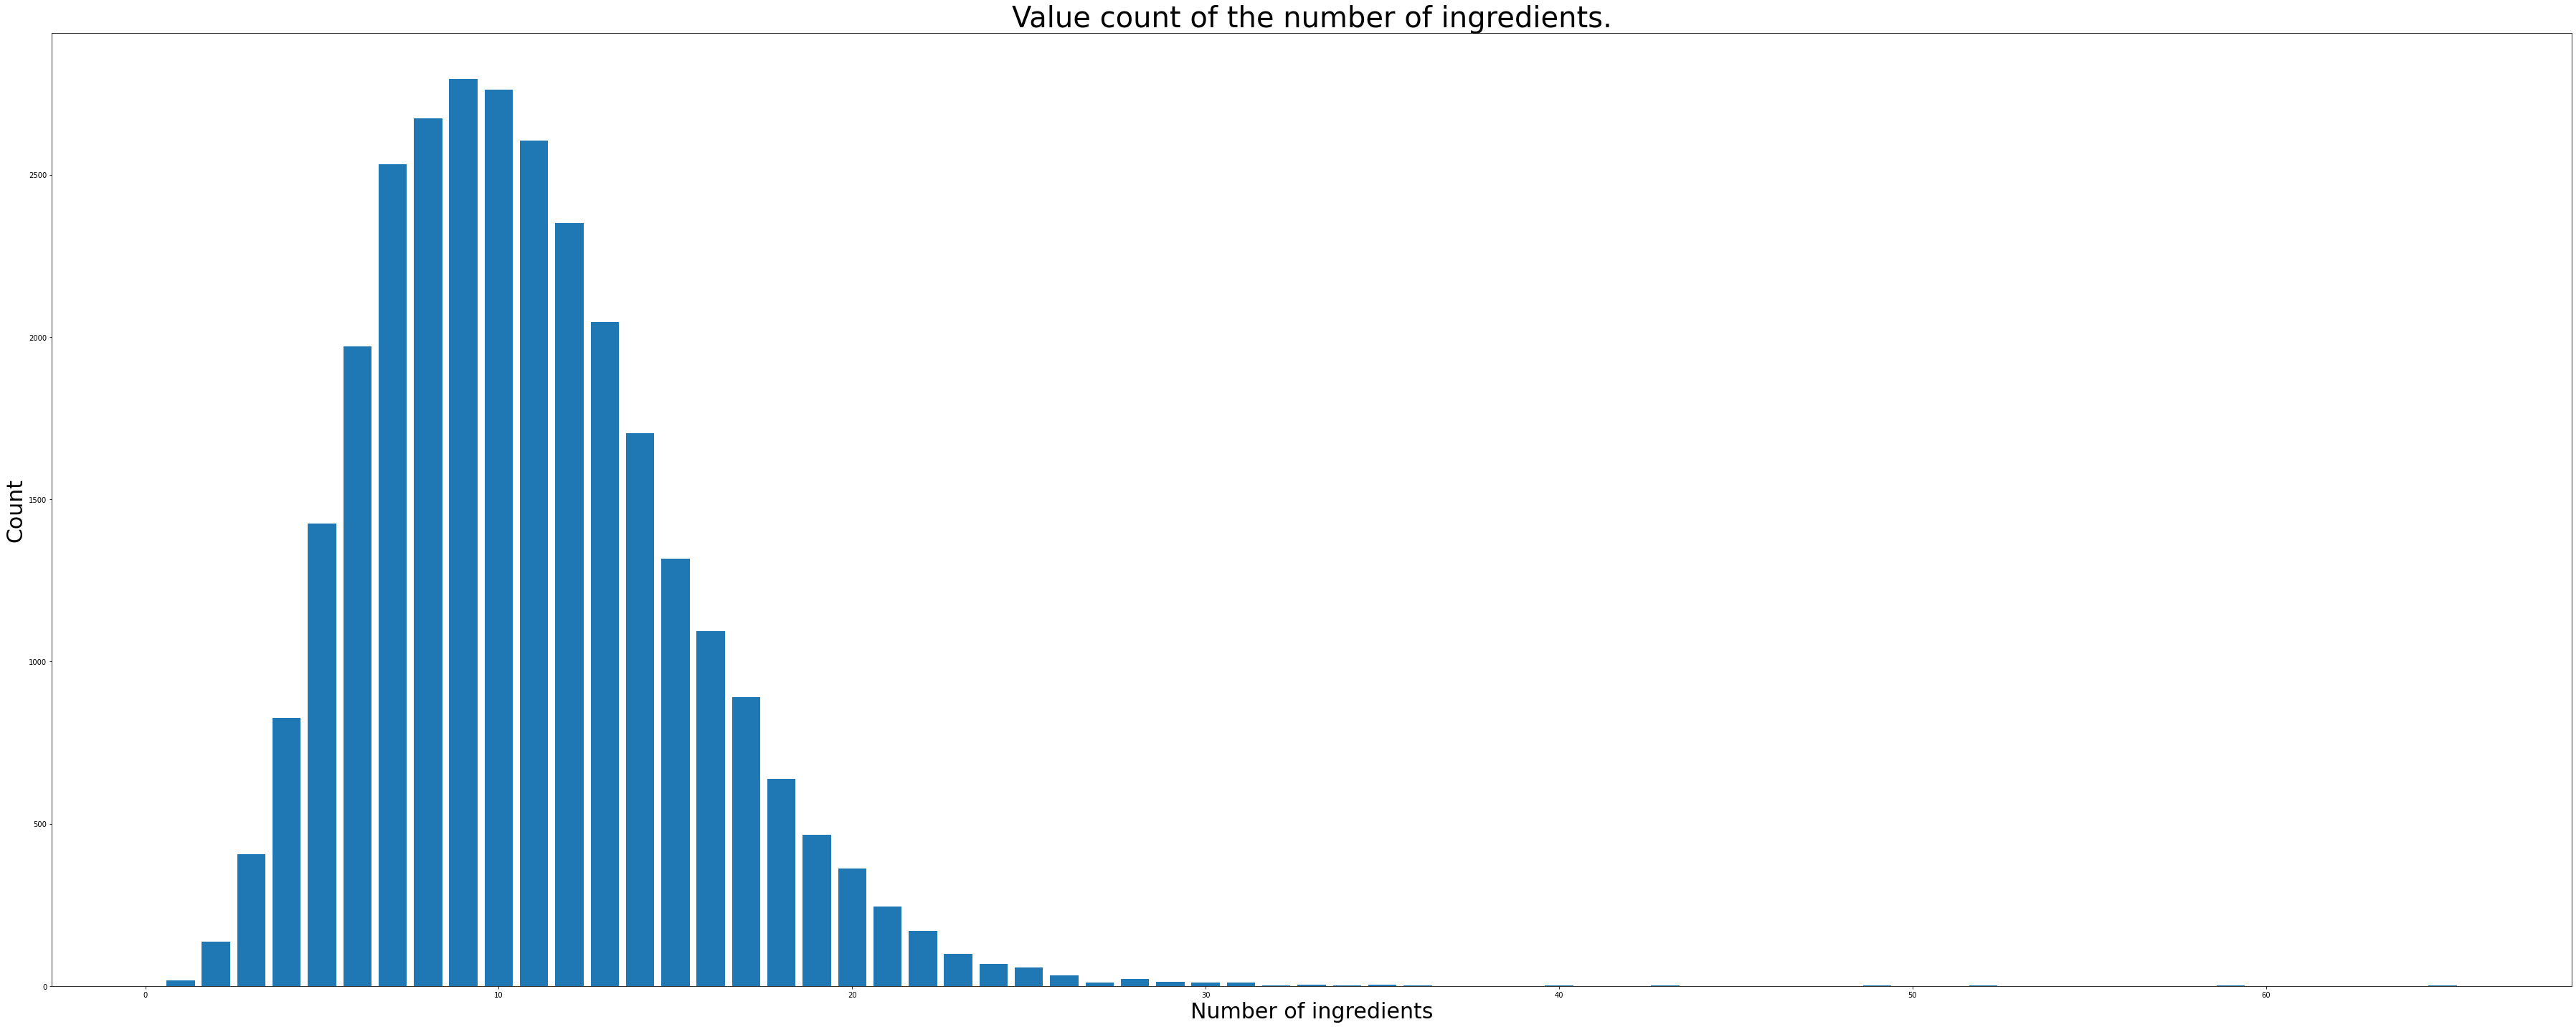

In [8]:
num_ing_val_cnt = pd.Series([len(li) for li in df['ingredients']]).value_counts()
plt.figure(figsize=(50, 20))
plt.bar(num_ing_val_cnt.index, num_ing_val_cnt.values)
plt.title("Value count of the number of ingredients.", fontsize=40) 
plt.ylabel("Count", fontsize=30) 
plt.xlabel("Number of ingredients", fontsize=30)
plt.tight_layout()

## Data Preprocessing 
因為資料比較大 所以我只取前3000比較常出現的 並將他們轉成one hot

In [9]:
# Choose top numFeature features
numFeature = 3000
df_one_hot = df.copy()

val_cnt = flatten(df['ingredients']).value_counts()[0:numFeature]
features_set = set(val_cnt.index)

df_one_hot = pd.concat([df_one_hot, pd.DataFrame(0, columns=val_cnt.index, index=df.index)], axis=1)

def one_hot(x):
    for c in x['ingredients']:
        if c in features_set:
            x[c] = 1
    return x
df_one_hot = df_one_hot.apply(one_hot, axis=1)

y = df_one_hot['cuisine']
X = df_one_hot.drop(['ingredients', 'id', 'cuisine'], axis=1)

確保不會有資料沒feature

In [10]:
mask = ~(X==0).all(axis=1)
X_new = X[mask]
y_new = y[mask]

將lable轉成integer

In [11]:
labelencoder = LabelEncoder()
y_new = labelencoder.fit_transform(y_new)
y_new

array([16,  6,  2, ...,  5, 13,  9])

## Validation Method

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3)

## Artificial Neural Networks
我用sklearn的MLPClassifier，hidden_layer只有一層(220) 原本試著多層一些 但效果不太好

In [13]:
clf = MLPClassifier(random_state=712223,max_iter=500, n_iter_no_change=5, verbose=True, solver='adam',early_stopping=True,hidden_layer_sizes=(220))
clf.fit(X_train.values, y_train)

Iteration 1, loss = 1.91316633
Validation score: 0.674664
Iteration 2, loss = 0.94141880
Validation score: 0.754798
Iteration 3, loss = 0.68087830
Validation score: 0.771113
Iteration 4, loss = 0.54853293
Validation score: 0.775912
Iteration 5, loss = 0.46208301
Validation score: 0.777351
Iteration 6, loss = 0.39895076
Validation score: 0.776392
Iteration 7, loss = 0.34807454
Validation score: 0.772553
Iteration 8, loss = 0.30857094
Validation score: 0.769194
Iteration 9, loss = 0.27591160
Validation score: 0.765355
Iteration 10, loss = 0.24792551
Validation score: 0.761036
Iteration 11, loss = 0.22509072
Validation score: 0.756718
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


MLPClassifier(early_stopping=True, hidden_layer_sizes=220, max_iter=500,
              n_iter_no_change=5, random_state=712223, verbose=True)

### Predict the test data (for validation)

In [14]:
y_pred = clf.predict(X_test.values)

## Results 
- Confusion matrix
- Accuracy
- Sensitivity (Recall)
- Precision

In [15]:
def show_metrics(metrics, lable):
    cm, acc, pc, recall = metrics
    num_classes = pc.size
    cm_row = list(map(lambda x: 'Predicted '+x, list(lable)))
    cm_col = list(map(lambda x: 'Actual '+x, list(lable)))
    
    display(pd.DataFrame(cm, index=cm_row, columns=cm_col))
    display(pd.DataFrame([acc], index=['Accuracy'], columns=['Avg.']))
    display(pd.DataFrame(pc.reshape(1, num_classes), index=['Precision'], columns=lable))
    display(pd.DataFrame(recall.reshape(1, num_classes), index=['Recall'], columns=lable))

In [16]:
cm = sklearn.metrics.confusion_matrix(y_test, y_pred).transpose()
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
precision, recall, _, _ = sklearn.metrics.precision_recall_fscore_support(y_test, y_pred)

In [17]:
show_metrics((cm, acc, precision, recall), labelencoder.inverse_transform(range(20)))

,Actual brazilian,Actual british,Actual cajun_creole,Actual chinese,Actual filipino,Actual french,Actual greek,Actual indian,Actual irish,Actual italian,Actual jamaican,Actual japanese,Actual korean,Actual mexican,Actual moroccan,Actual russian,Actual southern_us,Actual spanish,Actual thai,Actual vietnamese
Predicted brazilian,54,1,1,0,1,0,0,0,0,0,1,0,0,1,0,1,2,2,1,0
Predicted british,0,70,3,0,0,12,0,1,17,1,0,1,1,0,0,4,8,1,0,0
Predicted cajun_creole,2,2,235,2,2,8,0,0,2,7,1,1,0,4,0,3,46,4,0,0
Predicted chinese,0,0,0,486,21,2,0,3,3,3,3,38,18,6,0,0,8,1,23,21
Predicted filipino,0,0,0,5,97,1,0,0,1,1,1,2,1,1,0,2,2,1,7,2
Predicted french,1,27,12,2,6,388,8,6,28,86,2,9,1,13,2,15,28,22,0,2
Predicted greek,0,1,0,0,0,6,184,3,1,26,0,0,0,4,12,0,0,3,0,1
Predicted indian,4,5,1,2,0,5,5,599,0,6,4,31,0,5,18,2,8,4,7,3
Predicted irish,0,11,0,0,1,3,0,1,48,4,1,1,0,1,0,3,5,2,0,0
Predicted italian,3,16,15,7,4,110,52,4,17,1587,1,4,3,27,6,16,44,39,3,8


,Avg.
Accuracy,0.772814


,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
Precision,0.830769,0.588235,0.736677,0.764151,0.782258,0.589666,0.763485,0.844852,0.592593,0.807223,0.885057,0.768683,0.88125,0.875,0.877419,0.615385,0.710623,0.547739,0.748538,0.710526


,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
Recall,0.486486,0.421687,0.691176,0.852632,0.60625,0.631922,0.691729,0.902108,0.309677,0.870543,0.65812,0.685714,0.75,0.91844,0.697436,0.38835,0.785425,0.495455,0.778116,0.548223


## Comparison & Conclusion
參數好難調

## Kaggle Submission

### Train the model with all train data

In [18]:
clf.fit(X_new.values, y_new)

Iteration 1, loss = 1.66176399
Validation score: 0.732953
Iteration 2, loss = 0.80196890
Validation score: 0.771246
Iteration 3, loss = 0.60990298
Validation score: 0.774605
Iteration 4, loss = 0.51047476
Validation score: 0.782667
Iteration 5, loss = 0.44399067
Validation score: 0.781323
Iteration 6, loss = 0.39262983
Validation score: 0.776621
Iteration 7, loss = 0.35252252
Validation score: 0.774269
Iteration 8, loss = 0.31749166
Validation score: 0.772926
Iteration 9, loss = 0.29010865
Validation score: 0.771582
Iteration 10, loss = 0.26465689
Validation score: 0.769231
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


MLPClassifier(early_stopping=True, hidden_layer_sizes=220, max_iter=500,
              n_iter_no_change=5, random_state=712223, verbose=True)

### Read test.json

In [19]:
df_test = pd.json_normalize(test_data)

In [20]:
df_test

,id,ingredients
0,14,"[olive oil, balsamic vinegar, toasted pine nut..."
1,22,"[canola, jalapeno chilies, salsa, onions, cide..."
2,24,"[large eggs, vanilla extract, firmly packed li..."
3,37,"[queso fresco, margarine, chicken breasts, ext..."
4,40,"[active dry yeast, white sugar, warm water, sa..."
...,...,...
9995,49692,"[black pepper, vegetable oil, garlic cloves, u..."
9996,49693,"[crescent rolls, Nutella]"
9997,49697,"[fennel seeds, bread crumbs, salt, eggs, crush..."
9998,49709,"[shallots, salt, red, basil, tomato ketchup, p..."


### Processing test data(one hot)

In [21]:
df_test = pd.concat([df_test, pd.DataFrame(0, columns=val_cnt.index, index=df_test.index)], axis=1)
df_test = df_test.apply(one_hot, axis=1)

df_test = df_test.drop(['ingredients', 'id'], axis=1)

### Predict

In [22]:
y_pred_test = clf.predict(df_test.values)

### Output the prediction

In [23]:
df_ans = pd.json_normalize(test_data)
df_ans['Category'] = labelencoder.inverse_transform(y_pred_test)
df_ans = df_ans.drop('ingredients', axis = 1)
df_ans

,id,Category
0,14,italian
1,22,mexican
2,24,southern_us
3,37,mexican
4,40,italian
...,...,...
9995,49692,southern_us
9996,49693,italian
9997,49697,italian
9998,49709,italian


In [24]:
df_ans.to_csv('test_predict10.csv', index = False)

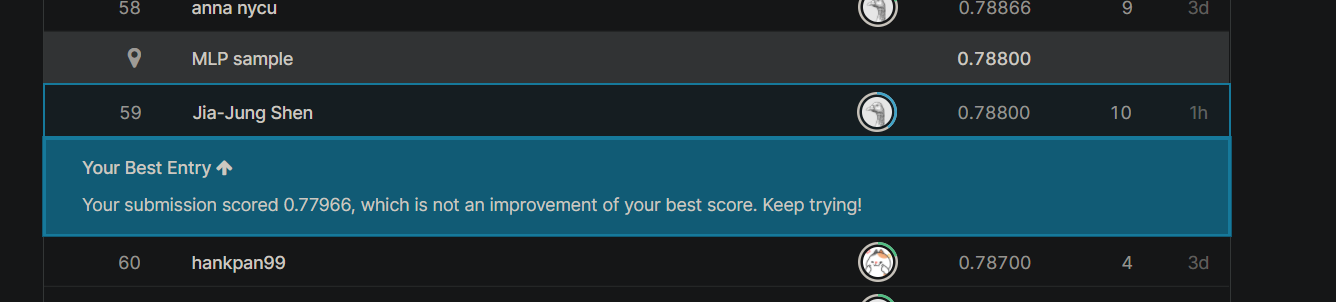